# NEU Data

First, I need to verify that python can find the original images so we can process them.

The NEU dataset contains 300 images for each defects. With 6 defects, there are 1800 total defects. 

All images are 200x200 grayscale bitmap images. The filenames indicate the defect class with the first 2 letters.

but I want to separate one of the classes for later novelty detection purposes so I will only use 1500 images. with 5 defects


# Module imports
I will use skimage to pre-process the images, pathlib to navigate files, and matplotlib for visualization.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import os
from pathlib import Path
import skimage.exposure
import skimage.io
import skimage.transform

%matplotlib inline

In [2]:
root = Path('NEU_dataset') # directory where original NEU images are stored
assert root.is_dir() # make sure this directory is found
files = sorted(root.glob('*.bmp'), key=lambda file : file.name) # read files and sort by name so order is consistent
assert len(files) == 1500 # make sure all 1500 images are found

# Pre-processing
I will take the following steps:
  * Load the image into python
  * Apply histogram equalization
  * Resize the image to 224 x 224 needed for use with VGG16
  * Save the image to disk

I will start with the process for a single image as an example, and then process all of them in one batch.

## Load image

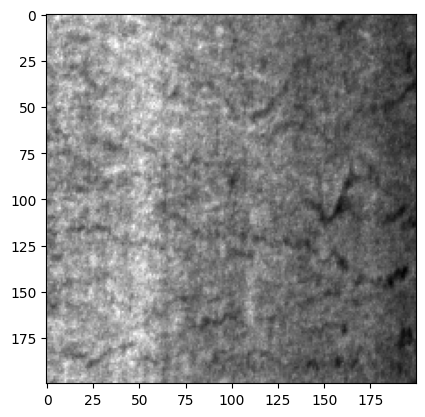

In [3]:
im_path = Path('NEU_dataset','Cr_10.bmp') # path to image
assert im_path.exists()

im = skimage.io.imread(im_path, as_gray=True) # load image

# display the image to verify it loads as expected
fig, ax = plt.subplots()
ax.imshow(im, cmap='gray')

## Histogram equalization

Histogram equalization stretches the contrast of an image. We will see the effect this can have below.

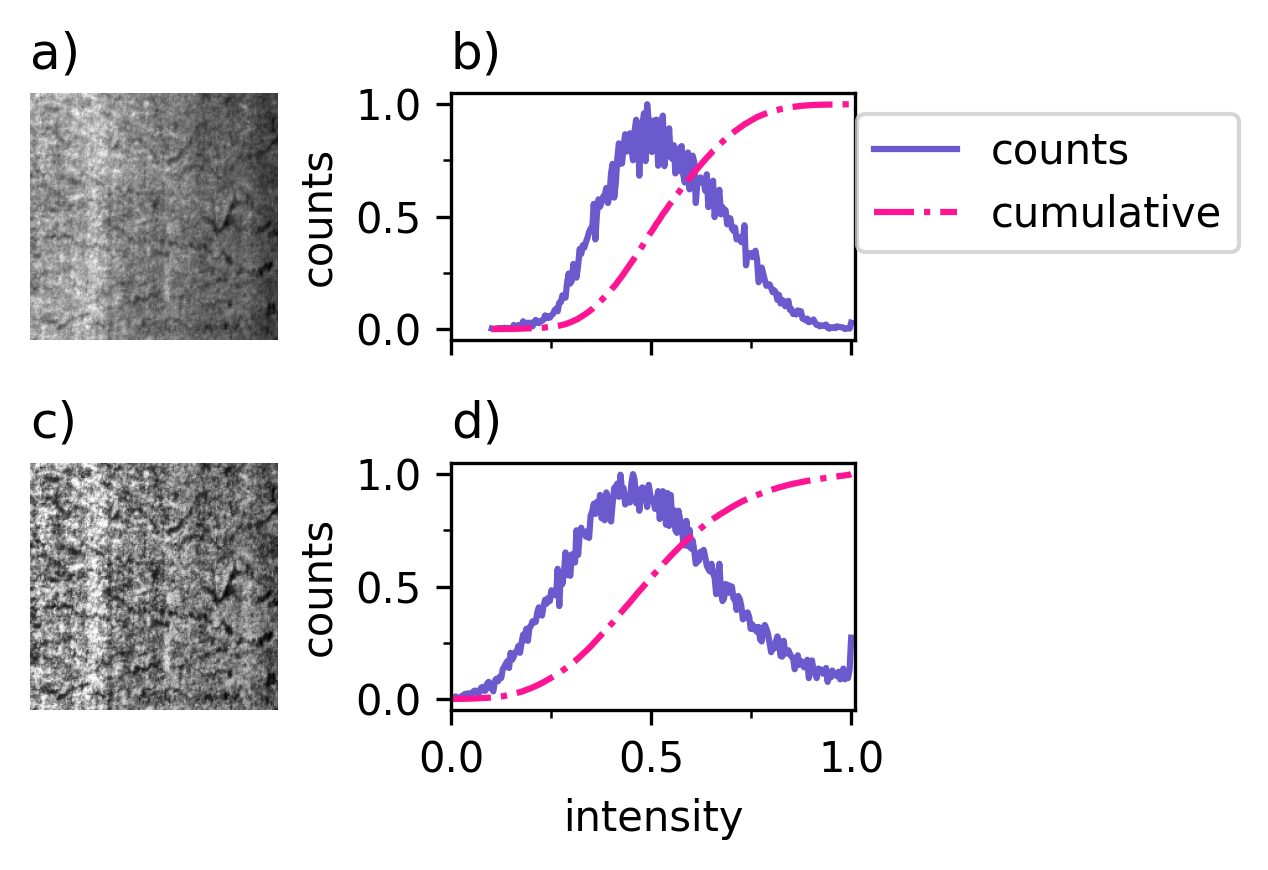

In [4]:
im = skimage.img_as_float32(im) # before applying histogram equalization we want to be sure that the image is represented with floating point pixel values between 0 and 1

im_eq = skimage.exposure.equalize_adapthist(im) # apply histogram equalization


# get histogram from each image
hist, bins = skimage.exposure.histogram(skimage.img_as_ubyte(im))
bins = bins/bins.max()
hist = hist/hist.max()
hist_cumsum = hist.cumsum() / hist.sum()

hist_eq, bins_eq = skimage.exposure.histogram(skimage.img_as_ubyte(im_eq))
bins_eq = bins_eq/bins_eq.max()
hist_eq = hist_eq / hist_eq.max()
hist_eq_cumsum = hist_eq.cumsum() / hist_eq.sum()

# visualize image and histograms before and after equalization
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=300, sharex=True, sharey=False)

# display images
ax[0,0].imshow(im, extent=(0,1,0,1), cmap='gray')
ax[1,0].imshow(im_eq, extent=(0,1,0,1), cmap='gray')

# plot intensity histograms
ax[0,1].plot(bins, hist, label='counts', linestyle='-', color='slateblue')
ax[0,1].plot(bins, hist_cumsum, label='cumulative', linestyle='-.', color='deeppink')
ax[1,1].plot(bins_eq, hist_eq, linestyle='-', color='slateblue')
ax[1,1].plot(bins_eq, hist_eq_cumsum, linestyle='-.', color='deeppink')

# label axes
ax[0,1].set_ylabel('counts')
ax[1,1].set_ylabel('counts')
ax[1,1].set_xlabel('intensity')

# legend
ax[0,1].legend(loc='upper right', bbox_to_anchor=(2,1), facecolor='w')

# turn off axes on image
ax[0,0].axis('off')
ax[1,0].axis('off')

# extend xlim so you can see edges of graph
ax[1,1].set_xlim([0,1.01])

# make titles
for a, title in zip(ax.ravel(), ['a)','b)','c)','d)']):
    a.set_title(title, loc='left')
for a in ax[:,1].ravel():
    a.set_yticks(np.linspace(0,1,3))
    a.set_yticks([0.25,0.75], minor=True)
    a.set_xticks(np.linspace(0,1,3))
    a.set_xticks([0.25,0.75], minor=True)

fig.tight_layout()
fig.savefig(Path('example_bmp','Figures','HistEQExample.png'), bbox_inches='tight')

The contrast is enhanced, and the histogram appears to be more normally distributed after equalization.

# Preprocessing all images
Along with histogram equalization, I need to resize the images, so they will fit with the VGG16 network. 

I define the process (load image, apply histogram equalization, resize image, save image) as a function, and then

apply the process to all of the images in the dataset.

In [5]:
# pre-process pipeline- standard
def pre_process_pipeline(inpath, outdir, eq_hist=True):
    """
    Preprocess images for standard analysis.
    
    Reads the image from inpath, applies contrast limited adaptive histogram equalization,
    resizes the images to 224 x 224 for VGG16, and then saves image to disk in directory outdir.
    
    Parameters
    -----------
    inpath: str or Path object 
        path to image to be pre-processed
    outdir: str or Path object
        root directory to save image after pre-processing.
    eq_hist: bool
        if True, skimage.exposure.equalize_adapthist is applied before resizing.
        (Can be disabled for sensitivity analysis)
    
    Saved
    -------
    im_preprocessed: image
            image is saved to disk in outdir with the same filename and image format as the original image.
    
    """
    name = Path(inpath).name # get the filename of the image
    im = skimage.io.imread(inpath, as_gray=True) # read in image
    im = skimage.img_as_float32(im) # convert to float representation for histogram equalization
    if eq_hist:
        im = skimage.exposure.equalize_adapthist(im) # histogram equalization
    im = skimage.transform.resize(im, (224,224)) # resize to 224 x 224 needed for VGG16
    im = skimage.img_as_ubyte(im) # convert back to 8 bit grayscale image
    skimage.io.imsave(Path(outdir, name), im) # save image to disk
    return

output_root = Path('..','data','images_preprocessed','images_histeq_resize') # place where pre-processed images will be stored
os.makedirs(output_root, exist_ok=True) # create output directory if it does not exist
for file in files:
    pre_process_pipeline(file, output_root)
assert len(list(output_root.glob("*.bmp"))) == 1500 # make sure all 1500 images processed